In [1]:
import time
import random
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from FH_Functions import opt_fracs, get_truncated_normal

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## The network is very similar to uniform network, only differences in environment and dqn func

In [2]:
#@title Qnet
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=16, fc2_units=16):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 1.00            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-3               # learning rate 
UPDATE_EVERY = 10       # how often to update the network

"""GPU only faster for larger networks"""
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

cpu


In [4]:
#@title Agent, Replay
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [5]:
#@title NON-UNIFORM Environment
class DQNNonUniformLineSearchEnv():
    def __init__(self, lam = 0.4, Nsamples = 5, Nstates = 501):
         
        self.lam      = lam
        self.Nactions = 101
        self.Nsamples = Nsamples
        self.S        = np.linspace(0,1,Nstates)
        self.reset()

    def step(self, action, theta):  # return the next state 
        done = False
        thtMin = self.thtMin
        thtMax = self.thtMax
        Xc = self.Xc
        Xo = self.Xo 
        N = self.state[1]
        
        size   = thtMax - thtMin        
        act    = 0.5 * (action / (self.Nactions-1))
        dist   = size * act
        dist   = self.S[np.argmin(np.abs(self.S - dist))]

        if Xc < theta:
            Xc = Xc + dist
        else:
            Xc = Xc - dist
            
        Xc = self.S[np.argmin(np.abs(self.S - Xc))]
        
        if Xc < theta:
            thtMin = Xc
            Xo = thtMax
        else:
            thtMax = Xc
            Xo = thtMin
            
        newSize = thtMax - thtMin
            
        reward = size - newSize - self.lam*dist
        
        self.thtMin = thtMin
        self.thtMax = thtMax
        self.Xc     = Xc
        self.Xo     = Xo
        self.state  = np.array([self.lam, N-1, self.Xc, self.Xo])
        
        if self.state[1] == 0:
            done = True
        return self.state, reward, done
    
    def reset(self):       
        self.thtMin = 0
        self.thtMax = 1
        self.Xc     = 0
        self.Xo     = 1
        self.state  = np.array([self.lam, self.Nsamples, self.Xc, self.Xo])
        return self.state

In [6]:
#@title DQN
def dqn(agent, env, n_episodes=2000, eps_start=1.0, eps_end=0.1, eps_decay=0.9999):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        target_scores (float): average scores aming to achieve, the agent will stop training once it reaches this scores
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    np.random.seed(1)
    thtDist = get_truncated_normal(0.5, 0.1, 0, 1)
    for i_episode in range(1, n_episodes+1):
        
        # Reset env and score at the beginning of episode
        thtRange = thtDist.rvs(100)           # draw 100 thetas from the distribution
        
        for tht in thtRange:
            state = env.reset()               # get the current state
            score = 0                         # initialize the score
            done  = False

            while not done:
                action = agent.act(state, eps)            
                next_state, reward, done = env.step(action, tht)            
                agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break 
            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.4f}\tEps: {:.4f}'.format(i_episode, np.mean(scores_window), eps), end="")
        
        if i_episode % 1000 == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}\tEps: {:.4f}'.format(i_episode, np.mean(scores_window), eps))
    
    return scores

In [7]:
Nsteps = 5
env   = DQNNonUniformLineSearchEnv(Nsamples = Nsteps)
agent = Agent(state_size=4, action_size=101, seed=0)

In [8]:
start = time.time()
scores = dqn(agent, env, n_episodes=5, eps_decay = 0.9995)
stop = time.time()
print("\ntime: %.2f"%(stop - start))

Episode 5	Average Score: 0.6266	Eps: 0.9975
time: 1.61


In [9]:
torch.save(agent.qnetwork_local.state_dict(), './Policies/DQN_Nonuniform_ReLU.pth')

In [14]:
"""Load in pre-saved agent if not re-training"""
agent = Agent(state_size=4, action_size=101, seed=0)
agent.qnetwork_local.to(device)
agent.qnetwork_local.load_state_dict(torch.load('./Policies/DQN_Nonuniform_ReLU.pth'))

<All keys matched successfully>

In [15]:
lam = 0.4
states = np.arange(1,Nsteps + 1)
DQNacts = np.zeros(Nsteps)
cost = 0

thtDist = get_truncated_normal(0.5, 0.1, 0, 1)
np.random.seed(0)
thtRange = thtDist.rvs(1000)

S = np.linspace(0,1,501)

for theta in thtRange:
    Xc = 0
    Xo = 1
    lb = 0
    ub = 1
    totDist = 0
    for ii in states[::-1]:
        length = ub - lb
        stt = np.array([lam, ii, Xc, Xo])
        action = agent.act(stt, 0)
        action = 0.5*action/101
        DQNacts[-ii] += action

        dist = length*action
        dist = S[np.argmin(np.abs(S - dist))]
        totDist += dist
        
        if Xc < theta:   
            Xc += dist

        else:
            Xc -= dist
            
        Xc = S[np.argmin(np.abs(S - Xc))]

        if Xc < theta:
            lb = Xc
            Xo = ub
        else:
            ub = Xc
            Xo = lb

    cost += lam*totDist + (ub - lb)
    
DQNacts /= 1000
cost /= 1000

Actions:  [0.34653465 0.15007921 0.18039604 0.25220792 0.29666832]
Average cost:  0.27586959999999994


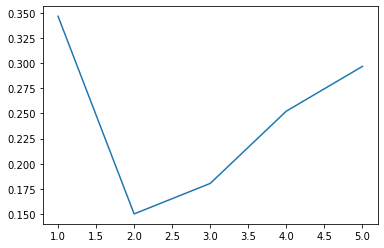

In [16]:
plt.plot(states,DQNacts)
print("Actions: ", DQNacts)
print("Average cost: ", cost)   
# np.save('./DQN_bestAction_mu5_sig1_lam4_N5_s501_A101',DQNacts)